In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# import raw data
demographics = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/raw data/demographic.csv')
als_hx = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/raw data/als_hx.csv')
alsfrs_total_3mo = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/raw data/alsfrs_total_3mo_meta_slope.csv')
fvc_3mo = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/raw data/fvc_3mo_meta.csv')
lab = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/raw data/lab.csv')
weight = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/raw data/weight.csv')
alsfrs_q_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/raw data/ALSFRS_original_final.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Extracting feature and target variables

## 1-1. Static features

In [ ]:
demographics = demographics[['SubjectID', 'Age', 'Gender']]
als_hx = als_hx[['SubjectID', 'diag_delta', 'onset_delta', 'onset_site']]
als_hx['diag_minus_onset'] = als_hx['diag_delta']-als_hx['onset_delta']

## 1-2. Time-resolved features

In [ ]:
fvc_3mo = fvc_3mo[['SubjectID', 'fvc_slope', 'fvc_mean']]
alsfrs_total_slope = alsfrs_total_3mo[['SubjectID', 'alsfrs_total_slope']]
alsfrs_q_raw = alsfrs_q_raw[['SubjectID', 'feature_delta', 'Q1_Speech','Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 
                             'Q5_Cutting','Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs', 'Q10_Respiratory']]
creatinine = lab[['SubjectID', 'feature_delta', 'Creatinine']]
weight = weight[['SubjectID', 'weight', 'feature_delta']]

### (1) Creatinine

In [ ]:
creatinine[creatinine['Creatinine']=='<18']

,SubjectID,feature_delta,Creatinine
41895,618981,560,<18
42758,631712,1095,<18


In [ ]:
creatinine = creatinine[creatinine['Creatinine']!='<18']
creatinine = creatinine.astype('float')
creatinine.dtypes

SubjectID        float64
feature_delta    float64
Creatinine       float64
dtype: object

In [ ]:
creatinine_3mo = creatinine.query('(feature_delta < 92) and (feature_delta >= 0)')
alsfrs_q_raw_3mo = alsfrs_q_raw.query('(feature_delta < 92) and (feature_delta >= 0)')
weight_3mo = weight.query('(feature_delta < 92) and (feature_delta >= 0)')

In [ ]:
C1 = creatinine_3mo.groupby('SubjectID').agg(['first', 'last'])
C1.reset_index()

SubjectID feature_delta       Creatinine       
                       first  last      first   last
0        329.0           0.0  72.0     88.400   0.00
1        348.0           0.0  90.0     53.040  53.04
2        533.0           0.0  91.0     79.560  79.56
3        649.0           0.0  61.0     53.040  53.04
4        708.0           0.0  91.0     88.400  88.40
...        ...           ...   ...        ...    ...
7707  999308.0           0.0  56.0     92.000  92.00
7708  999482.0           1.0  80.0     93.704  68.00
7709  999863.0           1.0  90.0        NaN    NaN
7710  999880.0           0.0  70.0     88.400  88.40
7711  999990.0           0.0  82.0     53.040  44.20

[7712 rows x 5 columns]

In [ ]:
C1['interval'] = C1[('feature_delta', 'last')] - C1[('feature_delta', 'first')]
C1['difference'] = C1[('Creatinine', 'last')] - C1[('Creatinine', 'first')]
C1 = C1[C1['interval']!=0]
C1['Creatinine_slope'] = C1['difference']/ C1['interval']
C1 = C1.reset_index()
C1

SubjectID feature_delta        ... interval difference Creatinine_slope
                       first  last  ...                                     
0        329.0           0.0  72.0  ...     72.0    -88.400        -1.227778
1        348.0           0.0  90.0  ...     90.0      0.000         0.000000
2        533.0           0.0  91.0  ...     91.0      0.000         0.000000
3        649.0           0.0  61.0  ...     61.0      0.000         0.000000
4        708.0           0.0  91.0  ...     91.0      0.000         0.000000
...        ...           ...   ...  ...      ...        ...              ...
5940  999308.0           0.0  56.0  ...     56.0      0.000         0.000000
5941  999482.0           1.0  80.0  ...     79.0    -25.704        -0.325367
5942  999863.0           1.0  90.0  ...     89.0        NaN              NaN
5943  999880.0           0.0  70.0  ...     70.0      0.000         0.000000
5944  999990.0           0.0  82.0  ...     82.0     -8.840        -0.107805

[5945 rows x 8 columns]

In [ ]:
C1[[('feature_delta', 'first'), ('feature_delta', 'last'), ('interval', '')]].describe()

feature_delta                  interval
              first         last             
count   5945.000000  5945.000000  5945.000000
mean       3.025568    69.935744    66.910177
std        9.172675    17.243269    18.309356
min        0.000000     1.000000     1.000000
25%        0.000000    62.000000    57.000000
50%        0.000000    71.000000    70.000000
75%        0.000000    84.000000    82.000000
max       85.000000    91.000000    91.000000

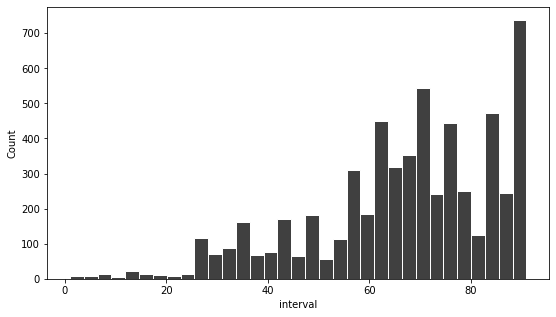

In [ ]:
plt.figure(figsize=(9,5))
sns.histplot(x = C1['interval'], color='k', edgecolor='w')

In [ ]:
C_slope = C1[['SubjectID', 'Creatinine_slope']]
C3 = creatinine_3mo.groupby('SubjectID').agg('mean').reset_index()
C_mean = C3[['SubjectID', 'Creatinine']]
Creatinine_summary = C_mean.merge(C_slope, on = 'SubjectID', how='inner')
Creatinine_summary.columns = ['SubjectID', 'Creatinine_mean', 'Creatinine_slope']
Creatinine_summary

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,SubjectID,Creatinine_mean,Creatinine_slope
0,329.0,58.933333,-1.227778
1,348.0,53.040000,0.000000
2,533.0,79.560000,0.000000
3,649.0,53.040000,0.000000
4,708.0,88.400000,0.000000
...,...,...,...
5940,999308.0,92.000000,0.000000
5941,999482.0,79.926000,-0.325367
5942,999863.0,NaN,NaN
5943,999880.0,88.400000,0.000000


### (2) alsfrs_q

In [ ]:
df = alsfrs_q_raw_3mo.groupby('SubjectID').agg('mean')
df = df.reset_index()
df

,SubjectID,feature_delta,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5_Cutting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory
0,329,27.600000,4.00,3.000000,4.000000,3.000000,1.900000,3.000000,2.600000,2.000000,1.200000,3.2
1,348,29.250000,4.00,4.000000,4.000000,3.500000,2.000000,2.250000,3.500000,2.000000,1.000000,4.0
2,533,34.333333,1.00,1.333333,2.000000,4.000000,4.000000,3.333333,4.000000,3.333333,2.666667,3.0
3,586,3.000000,0.00,2.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0
4,649,31.000000,3.00,3.000000,2.666667,3.666667,3.333333,4.000000,4.000000,4.000000,4.000000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6502,999166,18.000000,3.00,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,4.0
6503,999482,35.750000,2.75,2.750000,3.750000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.0
6504,999823,50.000000,2.75,3.000000,2.750000,4.000000,3.750000,3.000000,4.000000,4.000000,4.000000,4.0
6505,999880,28.000000,4.00,4.000000,4.000000,2.000000,1.000000,0.400000,2.800000,2.000000,0.000000,4.0


In [ ]:
df.drop(columns='feature_delta', inplace=True)

In [ ]:
df.columns=['SubjectID', 'mean_Q1_Speech', 'mean_Q2_Salivation', 'mean_Q3_Swallowing', 'mean_Q4_Handwriting', 
            'mean_Q5_Cutting','mean_Q6_Dressing_and_Hygiene', 'mean_Q7_Turning_in_Bed', 'mean_Q8_Walking', 'mean_Q9_Climbing_Stairs', 'mean_Q10_Respiratory']

In [ ]:
mean_alsfrs_q = df.copy()
mean_alsfrs_q

,SubjectID,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory
0,329,4.00,3.000000,4.000000,3.000000,1.900000,3.000000,2.600000,2.000000,1.200000,3.2
1,348,4.00,4.000000,4.000000,3.500000,2.000000,2.250000,3.500000,2.000000,1.000000,4.0
2,533,1.00,1.333333,2.000000,4.000000,4.000000,3.333333,4.000000,3.333333,2.666667,3.0
3,586,0.00,2.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0
4,649,3.00,3.000000,2.666667,3.666667,3.333333,4.000000,4.000000,4.000000,4.000000,4.0
...,...,...,...,...,...,...,...,...,...,...,...
6502,999166,3.00,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,4.0
6503,999482,2.75,2.750000,3.750000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.0
6504,999823,2.75,3.000000,2.750000,4.000000,3.750000,3.000000,4.000000,4.000000,4.000000,4.0
6505,999880,4.00,4.000000,4.000000,2.000000,1.000000,0.400000,2.800000,2.000000,0.000000,4.0


In [ ]:
df3 = alsfrs_q_raw_3mo.groupby('SubjectID').agg(['first', 'last'])
df3['interval'] = df3.iloc[:, 1] - df3.iloc[:, 0]
df3['slope_Q1_Speech'] = (df3.iloc[:,3] - df3.iloc[:,2])/df3['interval']
df3['slope_Q2_Salivation'] = (df3.iloc[:,5] - df3.iloc[:,4])/df3['interval']
df3['slope_Q3_Swallowing'] = (df3.iloc[:,7] - df3.iloc[:,6])/df3['interval']
df3['slope_Q4_Handwriting'] = (df3.iloc[:,9] - df3.iloc[:,8])/df3['interval']
df3['slope_Q5_Cutting'] = (df3.iloc[:,11] - df3.iloc[:,10])/df3['interval']
df3['slope_Q6_Dressing_and_Hygiene'] = (df3.iloc[:,13] - df3.iloc[:,12])/df3['interval']
df3['slope_Q7_Turning_in_Bed'] = (df3.iloc[:,15] - df3.iloc[:,14])/df3['interval']
df3['slope_Q8_Walking'] = (df3.iloc[:,17] - df3.iloc[:,16])/df3['interval']
df3['slope_Q9_Climbing_Stairs'] = (df3.iloc[:,19] - df3.iloc[:,18])/df3['interval']
df3['slope_Q10_Respiratory'] = (df3.iloc[:,21] - df3.iloc[:,20])/df3['interval']

In [ ]:
df3 = df3[df3['interval']!=0]
df3

feature_delta       ... slope_Q9_Climbing_Stairs slope_Q10_Respiratory
                  first last  ...                                               
SubjectID                     ...                                               
329                   0   72  ...                 0.013889              0.000000
348                   0   61  ...                 0.000000              0.000000
533                   0   91  ...                 0.010989              0.000000
649                   0   61  ...                 0.000000              0.000000
708                   0   91  ...                 0.000000             -0.010989
...                 ...  ...  ...                      ...                   ...
998908                0   68  ...                 0.000000              0.000000
999482                0   80  ...                 0.000000              0.000000
999823                9   91  ...                 0.000000              0.000000
999880                0   70  ...                 0.000000              0.000000
999990               12   68  ...                 0.000000              0.000000

[6167 rows x 33 columns]

In [ ]:
df4 = df3.iloc[:, 23:].reset_index()
slope_alsfrs_q = df4.copy()
slope_alsfrs_q

,SubjectID,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory
,,,,,,,,,,,
0,329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.013889,0.000000
1,348,0.000000,0.000000,0.000000,0.016393,0.000000,-0.016393,-0.016393,0.000000,0.000000,0.000000
2,533,-0.010989,-0.010989,0.000000,0.000000,0.000000,-0.010989,0.000000,0.010989,0.010989,0.000000
3,649,0.000000,0.000000,0.016393,0.000000,-0.016393,0.000000,0.000000,0.000000,0.000000,0.000000
4,708,0.000000,-0.010989,-0.010989,0.000000,0.000000,0.010989,0.000000,0.000000,0.000000,-0.010989
...,...,...,...,...,...,...,...,...,...,...,...
6162,998908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.014706,0.000000,0.000000,0.000000
6163,999482,-0.012500,-0.012500,-0.012500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6164,999823,-0.012195,0.000000,-0.012195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### (3) Weight slope

In [ ]:
W1 = weight_3mo.groupby('SubjectID').agg(['first', 'last'])
W1['interval'] = W1[('feature_delta', 'last')] - W1[('feature_delta', 'first')]
W1['difference'] = W1[('weight', 'last')] - W1[('weight', 'first')]
W1 = W1[W1['interval']!=0]
W1['weight_slope'] = W1['difference']/ W1['interval']
W1 = W1.reset_index()
weight_slope = W1[['SubjectID', 'weight_slope']]
weight_slope

,SubjectID,weight_slope
,,
0,329,-0.088889
1,348,0.060656
2,533,-0.005495
3,649,0.011475
4,708,-0.108791
...,...,...
5501,999761,-0.005495
5502,999823,-0.017582
5503,999880,-0.007143


## 1-3. Merging all features

In [ ]:
features = pd.DataFrame(columns=['SubjectID'])
feature_list = [demographics, als_hx, fvc_3mo, Creatinine_summary, alsfrs_total_slope, mean_alsfrs_q, slope_alsfrs_q, weight_slope]
for i in feature_list :
    df = i
    features = features.merge(df, on='SubjectID', how='outer')
features

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,Creatinine_mean,Creatinine_slope,alsfrs_total_slope,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,"(slope_Q1_Speech, )","(slope_Q2_Salivation, )","(slope_Q3_Swallowing, )","(slope_Q4_Handwriting, )","(slope_Q5_Cutting, )","(slope_Q6_Dressing_and_Hygiene, )","(slope_Q7_Turning_in_Bed, )","(slope_Q8_Walking, )","(slope_Q9_Climbing_Stairs, )","(slope_Q10_Respiratory, )","(weight_slope, )"
0,329,38.0,F,-1068.0,-1706.0,Limb,638.0,0.048171,101.25,58.933333,-1.227778,0.057181,4.0,3.000000,4.000000,3.000000,1.900000,3.000000,2.6,2.000000,1.200000,3.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.013889,0.0,-0.088889
1,348,52.0,F,-302.0,-501.0,Other,199.0,NaN,NaN,53.040000,0.000000,-0.009689,4.0,4.000000,4.000000,3.500000,2.000000,2.250000,3.5,2.000000,1.000000,4.0,0.000000,0.000000,0.000000,0.016393,0.000000,-0.016393,-0.016393,0.000000,0.000000,0.0,0.060656
2,533,65.0,F,-44.0,-1023.0,Bulbar,979.0,-0.583333,73.50,79.560000,0.000000,0.002114,1.0,1.333333,2.000000,4.000000,4.000000,3.333333,4.0,3.333333,2.666667,3.0,-0.010989,-0.010989,0.000000,0.000000,0.000000,-0.010989,0.000000,0.010989,0.010989,0.0,-0.005495
3,586,63.0,M,-507.0,-715.0,Bulbar,208.0,NaN,26.00,NaN,NaN,NaN,0.0,2.000000,1.000000,4.000000,4.000000,4.000000,4.0,4.000000,4.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,649,48.0,F,NaN,NaN,NaN,NaN,-0.082707,94.00,53.040000,0.000000,-0.000537,3.0,3.000000,2.666667,3.666667,3.333333,4.000000,4.0,4.000000,4.000000,4.0,0.000000,0.000000,0.016393,0.000000,-0.016393,0.000000,0.000000,0.000000,0.000000,0.0,0.011475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9839,996669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9840,996888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9841,998661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9842,99872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
features.columns = ['SubjectID','Age', 'Gender','diag_delta', 'onset_delta', 'onset_site','diag_minus_onset','fvc_slope','fvc_mean', 'Creatinine_mean', 'Creatinine_slope',
                        'alsfrs_total_slope','mean_Q1_Speech','mean_Q2_Salivation','mean_Q3_Swallowing','mean_Q4_Handwriting', 'mean_Q5_Cutting','mean_Q6_Dressing_and_Hygiene', 'mean_Q7_Turning_in_Bed',
                           'mean_Q8_Walking', 'mean_Q9_Climbing_Stairs','mean_Q10_Respiratory','slope_Q1_Speech','slope_Q2_Salivation','slope_Q3_Swallowing','slope_Q4_Handwriting',
                    'slope_Q5_Cutting','slope_Q6_Dressing_and_Hygiene', 'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking','slope_Q9_Climbing_Stairs','slope_Q10_Respiratory', 'weight_slope']

In [ ]:
feature_drop_delta = features.dropna(subset=['onset_delta', 'onset_site'])
feature_drop_delta

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,Creatinine_mean,Creatinine_slope,alsfrs_total_slope,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,weight_slope
0,329,38.0,F,-1068.0,-1706.0,Limb,638.0,0.048171,101.25,58.933333,-1.227778,0.057181,4.00,3.000000,4.000000,3.000000,1.90,3.000000,2.600000,2.000000,1.200000,3.200000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.027778,0.000000,0.013889,0.000000,-0.088889
1,348,52.0,F,-302.0,-501.0,Other,199.0,NaN,NaN,53.040000,0.000000,-0.009689,4.00,4.000000,4.000000,3.500000,2.00,2.250000,3.500000,2.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.016393,0.0,-0.016393,-0.016393,0.000000,0.000000,0.000000,0.060656
2,533,65.0,F,-44.0,-1023.0,Bulbar,979.0,-0.583333,73.50,79.560000,0.000000,0.002114,1.00,1.333333,2.000000,4.000000,4.00,3.333333,4.000000,3.333333,2.666667,3.000000,-0.010989,-0.010989,0.000000,0.000000,0.0,-0.010989,0.000000,0.010989,0.010989,0.000000,-0.005495
3,586,63.0,M,-507.0,-715.0,Bulbar,208.0,NaN,26.00,NaN,NaN,NaN,0.00,2.000000,1.000000,4.000000,4.00,4.000000,4.000000,4.000000,4.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,708,46.0,M,-986.0,-1070.0,Bulbar,84.0,-0.061928,51.00,88.400000,0.000000,-0.015037,3.00,2.833333,2.666667,3.166667,3.75,3.166667,4.000000,4.000000,2.833333,2.833333,0.000000,-0.010989,-0.010989,0.000000,0.0,0.010989,0.000000,0.000000,0.000000,-0.010989,-0.108791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8647,999761,62.0,M,-201.0,-717.0,Limb,516.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005495
8648,999823,55.0,M,-84.0,-492.0,Limb,408.0,-0.025981,100.80,NaN,NaN,-0.025446,2.75,3.000000,2.750000,4.000000,3.75,3.000000,4.000000,4.000000,4.000000,4.000000,-0.012195,0.000000,-0.012195,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.017582
8650,999880,51.0,M,-2105.0,-2865.0,Limb,760.0,-0.079112,50.25,88.400000,0.000000,0.011583,4.00,4.000000,4.000000,2.000000,1.00,0.400000,2.800000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.014286,0.000000,0.000000,0.000000,0.000000,-0.007143
8651,999929,56.0,M,-107.0,-411.0,Limb,304.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.069048


In [ ]:
feature_drop_delta.isnull().sum()

SubjectID                           0
Age                                 0
Gender                              0
diag_delta                          0
onset_delta                         0
onset_site                          0
diag_minus_onset                    0
fvc_slope                        1348
fvc_mean                         1049
Creatinine_mean                  1756
Creatinine_slope                 1756
alsfrs_total_slope                595
mean_Q1_Speech                    365
mean_Q2_Salivation                365
mean_Q3_Swallowing                365
mean_Q4_Handwriting               365
mean_Q5_Cutting                   365
mean_Q6_Dressing_and_Hygiene      365
mean_Q7_Turning_in_Bed            365
mean_Q8_Walking                   365
mean_Q9_Climbing_Stairs           365
mean_Q10_Respiratory              365
slope_Q1_Speech                   595
slope_Q2_Salivation               595
slope_Q3_Swallowing               595
slope_Q4_Handwriting              595
slope_Q5_Cut

In [ ]:
feature_drop_delta_mean = feature_drop_delta.dropna(subset=['mean_Q1_Speech'])
feature_drop_delta_mean.isnull().sum()

SubjectID                           0
Age                                 0
Gender                              0
diag_delta                          0
onset_delta                         0
onset_site                          0
diag_minus_onset                    0
fvc_slope                         983
fvc_mean                          704
Creatinine_mean                  1392
Creatinine_slope                 1392
alsfrs_total_slope                230
mean_Q1_Speech                      0
mean_Q2_Salivation                  0
mean_Q3_Swallowing                  0
mean_Q4_Handwriting                 0
mean_Q5_Cutting                     0
mean_Q6_Dressing_and_Hygiene        0
mean_Q7_Turning_in_Bed              0
mean_Q8_Walking                     0
mean_Q9_Climbing_Stairs             0
mean_Q10_Respiratory                0
slope_Q1_Speech                   230
slope_Q2_Salivation               230
slope_Q3_Swallowing               230
slope_Q4_Handwriting              230
slope_Q5_Cut

## 1-4. Optimal target

In [ ]:
alsfrs_orig_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/raw data/ALSFRS_original_final.csv')
fvc_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/raw data/fvc.csv')

### Subtracting [initial FVC < 50]

In [ ]:
fvc_a = fvc_raw.groupby('SubjectID').agg(['first', 'last'])
fvc_a = fvc_a.reset_index()
fvc_a

SubjectID fvc_percent      feature_delta     
                     first last         first last
0           89          75   75             0    0
1          329          98   93             0  274
2          406          83   83             0    0
3          411          79   79             0    0
4          533          77   70             0   12
...        ...         ...  ...           ...  ...
7307    999482          79   33             0  434
7308    999823         103   94             0  184
7309    999863          40   36             0  177
7310    999880          53   49             0  266
7311    999990          88   86            12   68

[7312 rows x 5 columns]

In [ ]:
# Remove rows with 'last feature_delta == first feature_delta'
fvc_a = fvc_a[fvc_a[('feature_delta', 'last')]!= fvc_a[('feature_delta', 'first')]]
fvc_a

SubjectID fvc_percent      feature_delta     
                     first last         first last
1          329          98   93             0  274
4          533          77   70             0   12
6          649          97   33             0  557
7          708          53   33             0  231
8          902          90   87             0  154
...        ...         ...  ...           ...  ...
7307    999482          79   33             0  434
7308    999823         103   94             0  184
7309    999863          40   36             0  177
7310    999880          53   49             0  266
7311    999990          88   86            12   68

[6073 rows x 5 columns]

In [ ]:
# Select rows with 'first fvc_percent < 50'
fvc_a = fvc_a[fvc_a[('fvc_percent', 'first')]<50]
fvc_a = fvc_a.reset_index().drop(columns='index')
fvc_extent_to_remove = list(fvc_a['SubjectID'])

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


### Subtracting [initial Q3 score <=2 ]

In [ ]:
alsfrs_Sw = alsfrs_orig_raw[['SubjectID', 'feature_delta', 'Q3_Swallowing']].reindex(columns=['SubjectID', 'Q3_Swallowing', 'feature_delta'])
alsfrs_Sw_a = alsfrs_Sw.groupby('SubjectID').agg(['first'])
alsfrs_Sw_b = alsfrs_Sw_a[alsfrs_Sw_a[('Q3_Swallowing','first')]>2].reset_index()
alsfrs_Sw_b

,SubjectID,Q3_Swallowing,feature_delta
,,first,first
0,329,4.0,0
1,348,4.0,0
2,708,3.0,0
3,902,3.0,7
4,1234,4.0,0
...,...,...,...
5862,999166,4.0,18
5863,999482,4.0,0
5864,999823,3.0,9


In [ ]:
alsfrs_filtered_extent = list(alsfrs_Sw_b['SubjectID'])

In [ ]:
# Subtract [FVC < 50] & [first ALSFRS Q3 <=2.0]
alsfrs_Sw = alsfrs_Sw.query("SubjectID == {0}".format(alsfrs_filtered_extent))
alsfrs_Sw = alsfrs_Sw[~alsfrs_Sw['SubjectID'].isin(fvc_extent_to_remove)]

### Time of [Q3 score == 2.0]

In [ ]:
# Find the first time of [ALSFRS_Q3 <= 2.0]
Optimal_event = alsfrs_Sw[alsfrs_Sw['Q3_Swallowing']<=2].groupby('SubjectID').agg(['first']).reset_index()
Optimal_event

,SubjectID,Q3_Swallowing,feature_delta
,,first,first
0,708,2.0,35
1,1234,1.0,245
2,1736,2.0,187
3,3551,2.0,130
4,3870,2.0,97
...,...,...,...
1871,996997,2.0,116
1872,998047,2.0,300
1873,998894,0.0,365


In [ ]:
# Coding [ALSFRS-Q3<=2] event as '1'
Optimal_event_1 = Optimal_event.iloc[:, [0,-1]]
Optimal_event_1.columns = ['SubjectID', 'time_opt']

Optimal_event_1_sublist = list(Optimal_event['SubjectID'])

Optimal_event_1['status_opt'] = 1
print("There are",len(Optimal_event_1['SubjectID'].unique()), "subjects whose status_opt = 1")

# Otherwise '0'
Optimal_event_0 = alsfrs_Sw[~alsfrs_Sw['SubjectID'].isin(Optimal_event_1_sublist)]
Optimal_event_0 = Optimal_event_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=('Q3_Swallowing', 'last'))
Optimal_event_0.columns = ['SubjectID', 'time_opt']
Optimal_event_0['status_opt'] = 0
print("There are",len(Optimal_event_0['SubjectID'].unique()), "subjects whose status_opt = 0")

There are 1876 subjects whose status_opt = 1
There are 3794 subjects whose status_opt = 0


In [ ]:
alsfrs_Sw_coded = pd.concat([Optimal_event_1, Optimal_event_0]).sort_values(by='SubjectID', axis=0)
alsfrs_Sw_coded = alsfrs_Sw_coded.reset_index()
alsfrs_Sw_coded.drop(columns='index', inplace=True)

In [ ]:
Optimal_Gas = alsfrs_Sw_coded.copy()
sub_list = list(Optimal_Gas['SubjectID'])
Optimal_Gas

,SubjectID,time_opt,status_opt
0,329,274,0
1,348,401,0
2,708,35,1
3,902,154,0
4,1234,245,1
...,...,...,...
5665,999166,390,0
5666,999482,317,1
5667,999823,91,1
5668,999880,266,0


## 1-5. Real target

In [ ]:
alsfrs_orig= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/raw data/ALSFRS_original_final.csv')

In [ ]:
gastro = alsfrs_orig[['SubjectID', 'Q5b_Cutting_with_Gastrostomy', 'feature_delta']].sort_values(by=['SubjectID', 'feature_delta'], axis=0).reset_index().drop(columns='index')
gastro

,SubjectID,Q5b_Cutting_with_Gastrostomy,feature_delta
0,329,NaN,0
1,329,NaN,8
2,329,NaN,16
3,329,NaN,42
4,329,NaN,72
...,...,...,...
59255,999990,NaN,12
59256,999990,NaN,40
59257,999990,NaN,68
59258,999990,NaN,97


In [ ]:
def checking_censored(x):
  
  if x.isnull().sum() == 0:
    return "Left censored"
  elif x.notnull().sum() == 0:
    return "Right censored"
  else:
    return "Normal"

aggs_by_col = {'Q5b_Cutting_with_Gastrostomy': [checking_censored], 'feature_delta': ['last']}
gastro_a = gastro.groupby('SubjectID', as_index=False).agg(aggs_by_col)
gastro_a

,SubjectID,Q5b_Cutting_with_Gastrostomy,feature_delta
,,checking_censored,last
0,329,Right censored,274
1,348,Right censored,401
2,533,Normal,378
3,586,Right censored,3
4,649,Normal,557
...,...,...,...
6505,999166,Right censored,390
6506,999482,Right censored,434
6507,999823,Left censored,184


In [ ]:
#Subtract Left censored data

gastro_a.columns = ['SubjectID', 'checking_censored', 'last_feature_delta']
gastro_a = gastro_a[gastro_a['checking_censored'] != 'Left censored']
full_extent = list(gastro_a['SubjectID'])
Right_censored_extent = list(gastro_a[gastro_a['checking_censored'] == 'Right censored']['SubjectID'])
Normal_extent = list(gastro_a[gastro_a['checking_censored'] == 'Normal']['SubjectID'])

print("Total number is " + str(len(full_extent)))
print("There are " + str(len(Right_censored_extent)) + " right censored data")
print("There are " + str(len(Normal_extent)) + " normal data")

Total number is 5797
There are 4609 right censored data
There are 1188 normal data


In [ ]:
# Create gastro_event_0

gastro_event_0 = gastro_a[gastro_a['checking_censored'] == 'Right censored']
gastro_event_0 = gastro_event_0.replace({'checking_censored':{'Right censored': 0}})
gastro_event_0.columns = ['SubjectID', 'status', 'time']
gastro_event_0

,SubjectID,status,time
0,329,0,274
1,348,0,401
3,586,0,3
5,708,0,231
11,2416,0,2
...,...,...,...
6504,998908,0,560
6505,999166,0,390
6506,999482,0,434
6508,999880,0,266


In [ ]:
gastro_b = gastro.copy()
gastro_b.query("SubjectID == {0}".format(Normal_extent), inplace=True)
gastro_b = gastro_b.dropna(axis=0)
gastro_event_1 = pd.DataFrame(gastro_b.groupby('SubjectID')['feature_delta'].agg('first')).reset_index()
gastro_event_1.columns = ['SubjectID', 'time']
gastro_event_1['status'] = 1
gastro_event_1

,SubjectID,time,status
0,533,287,1
1,649,487,1
2,1064,0,1
3,1234,245,1
4,1736,0,1
...,...,...,...
1183,995893,175,1
1184,996401,420,1
1185,996711,379,1
1186,998047,551,1


In [ ]:
gastro_event_1 = gastro_event_1[gastro_event_1['time'] != 0]
gastro_event_1

,SubjectID,time,status
0,533,287,1
1,649,487,1
3,1234,245,1
5,3551,501,1
6,4803,98,1
...,...,...,...
1183,995893,175,1
1184,996401,420,1
1185,996711,379,1
1186,998047,551,1


In [ ]:
gastro_fin = pd.concat([gastro_event_1, gastro_event_0]).sort_values(by='SubjectID', axis=0)
gastro_fin = gastro_fin.reset_index().drop(columns = 'index')

In [ ]:
gastro_fin.columns = ['SubjectID', 'time_real', 'status_real']
gastro_fin = gastro_fin[gastro_fin['time_real']>92]
gastro_fin

,SubjectID,time_real,status_real
0,329,274,0
1,348,401,0
2,533,287,1
4,649,487,1
5,708,231,0
...,...,...,...
5574,998908,560,0
5575,999166,390,0
5576,999482,434,0
5577,999880,266,0


In [ ]:
feature_drop_delta_mean.to_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/dataset/0725/feature-with-nans.csv')
Optimal_Gas.to_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/dataset/0725/opt-target.csv')
gastro_fin.to_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/dataset/0725/real-target.csv')

2. Data imputation

In [ ]:
pip install -U scikit-learn

     |████████████████████████████████| 22.3 MB 1.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/dataset/0725/feature-with-nans.csv')

In [ ]:
Gend = {"F":0, "M":1}
onsetsite = {"Other":0, "Bulbar":1, "Limb":0, "Limb and Bulbar":0}

X = X.replace({'Gender':Gend})
X = X.replace({'onset_site':onsetsite})

In [ ]:
columns = X.columns
imputer = IterativeImputer(sample_posterior = True)
ar = imputer.fit_transform(X)
X_imputed = pd.DataFrame(ar, columns = columns)

In [ ]:
X_imputed.columns

Index(['SubjectID', 'Age', 'Gender', 'diag_delta', 'onset_delta', 'onset_site',
       'diag_minus_onset', 'fvc_slope', 'fvc_mean', 'Creatinine_mean',
       'Creatinine_slope', 'alsfrs_total_slope', 'mean_Q1_Speech',
       'mean_Q2_Salivation', 'mean_Q3_Swallowing', 'mean_Q4_Handwriting',
       'mean_Q5_Cutting', 'mean_Q6_Dressing_and_Hygiene',
       'mean_Q7_Turning_in_Bed', 'mean_Q8_Walking', 'mean_Q9_Climbing_Stairs',
       'mean_Q10_Respiratory', 'slope_Q1_Speech', 'slope_Q2_Salivation',
       'slope_Q3_Swallowing', 'slope_Q4_Handwriting', 'slope_Q5_Cutting',
       'slope_Q6_Dressing_and_Hygiene', 'slope_Q7_Turning_in_Bed',
       'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs', 'slope_Q10_Respiratory',
       'weight_slope'],
      dtype='object')

In [ ]:
X_imputed.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
X_imputed.to_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/dataset/0725/X_iter_imputed.csv')

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
knnimputer = KNNImputer(n_neighbors=64)

In [ ]:
X_imputed_KNN = knnimputer.fit_transform(X)

In [ ]:
X_imputed_KNN = pd.DataFrame(X_imputed_KNN)
X_imputed_KNN.columns = ['index','SubjectID', 'Age', 'Gender', 'diag_delta', 'onset_delta', 'onset_site',
       'diag_minus_onset', 'fvc_slope', 'fvc_mean', 'Creatinine_mean',
       'Creatinine_slope', 'alsfrs_total_slope', 'mean_Q1_Speech',
       'mean_Q2_Salivation', 'mean_Q3_Swallowing', 'mean_Q4_Handwriting',
       'mean_Q5_Cutting', 'mean_Q6_Dressing_and_Hygiene',
       'mean_Q7_Turning_in_Bed', 'mean_Q8_Walking', 'mean_Q9_Climbing_Stairs',
       'mean_Q10_Respiratory', 'slope_Q1_Speech', 'slope_Q2_Salivation',
       'slope_Q3_Swallowing', 'slope_Q4_Handwriting', 'slope_Q5_Cutting',
       'slope_Q6_Dressing_and_Hygiene', 'slope_Q7_Turning_in_Bed',
       'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs', 'slope_Q10_Respiratory',
       'weight_slope']

In [ ]:
X_imputed_KNN.drop(columns='index', inplace=True)

In [ ]:
X_imputed_KNN.to_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/dataset/0725/X_knn_imputed.csv')

In [ ]:
X_imputed_KNN

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,Creatinine_mean,Creatinine_slope,alsfrs_total_slope,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,weight_slope
0,329.0,38.0,0.0,-1068.0,-1706.0,0.0,638.0,0.048171,101.250000,58.933333,-1.227778,0.057181,4.000000,3.000000,4.000000,3.000000,1.90,3.000000,2.600000,2.000000,1.200000,3.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.013889,0.000000,-0.088889
1,348.0,52.0,0.0,-302.0,-501.0,0.0,199.0,-0.134960,77.216667,53.040000,0.000000,-0.009689,4.000000,4.000000,4.000000,3.500000,2.00,2.250000,3.500000,2.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.016393,0.000000,-0.016393,-0.016393,0.000000,0.000000,0.000000,0.060656
2,533.0,65.0,0.0,-44.0,-1023.0,1.0,979.0,-0.583333,73.500000,79.560000,0.000000,0.002114,1.000000,1.333333,2.000000,4.000000,4.00,3.333333,4.000000,3.333333,2.666667,3.000000,-0.010989,-0.010989,0.000000,0.000000,0.000000,-0.010989,0.000000,0.010989,0.010989,0.000000,-0.005495
3,586.0,63.0,1.0,-507.0,-715.0,1.0,208.0,-0.131289,26.000000,75.853521,-0.038089,-0.027954,0.000000,2.000000,1.000000,4.000000,4.00,4.000000,4.000000,4.000000,4.000000,4.000000,-0.002547,-0.000960,-0.004619,-0.003335,-0.001454,-0.005733,-0.000336,-0.004100,-0.004924,-0.000131,-0.018093
4,708.0,46.0,1.0,-986.0,-1070.0,1.0,84.0,-0.061928,51.000000,88.400000,0.000000,-0.015037,3.000000,2.833333,2.666667,3.166667,3.75,3.166667,4.000000,4.000000,2.833333,2.833333,0.000000,-0.010989,-0.010989,0.000000,0.000000,0.010989,0.000000,0.000000,0.000000,-0.010989,-0.108791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,998756.0,64.0,1.0,-241.0,-612.0,1.0,371.0,-0.255102,73.333333,72.802583,-0.038328,-0.017439,2.666667,2.666667,3.000000,3.000000,3.00,3.000000,4.000000,3.000000,3.000000,2.000000,0.000000,-0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.039993
4084,999166.0,60.0,1.0,-49.0,-999.0,1.0,950.0,-0.333333,75.000000,83.980000,0.192174,-0.032683,3.000000,3.000000,4.000000,4.000000,4.00,4.000000,3.000000,3.000000,3.000000,4.000000,-0.000960,-0.001363,-0.002897,-0.003309,-0.005887,-0.004555,-0.004971,-0.002516,-0.001533,-0.004222,-0.027778
4085,999823.0,55.0,1.0,-84.0,-492.0,0.0,408.0,-0.025981,100.800000,72.802583,-0.038328,-0.025446,2.750000,3.000000,2.750000,4.000000,3.75,3.000000,4.000000,4.000000,4.000000,4.000000,-0.012195,0.000000,-0.012195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.017582
4086,999880.0,51.0,1.0,-2105.0,-2865.0,0.0,760.0,-0.079112,50.250000,88.400000,0.000000,0.011583,4.000000,4.000000,4.000000,2.000000,1.00,0.400000,2.800000,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014286,0.000000,0.000000,0.000000,0.000000,-0.007143


3. Concat feature and target

In [ ]:
features_final = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/dataset/0723_feature_without_nans.csv')
opt_target = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/dataset/0723_opt_target.csv')
real_target = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/PACTALS/dataset/0723_real_target.csv')
surv_target = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/survival.csv')

In [ ]:
surv_target.columns = ['SubjectID', 'time_surv', 'status_surv']
surv_target

,SubjectID,time_surv,status_surv
0,89,173,1
1,329,274,0
2,411,141,1
3,533,378,0
4,649,557,0
...,...,...,...
9075,996711,471,0
9076,996808,461,0
9077,997367,700,0
9078,997496,189,0


In [ ]:
feat_opt = features_final.merge(opt_target, on='SubjectID', how='inner')
feat_opt.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace =True)

In [ ]:
feat_opt

In [ ]:
feat_opt_n_real = feat_opt.merge(real_target, on='SubjectID', how='inner')
feat_opt_n_real.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
feat_surv = features_final.merge(surv_target, on='SubjectID', how='inner')
feat_surv.drop(columns='Unnamed: 0', inplace =True)

In [ ]:
feat_opt_real_n_surv = feat_opt_n_real.merge(surv_target, on='SubjectID', how='inner')
feat_opt_real_n_surv

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,Creatinine_mean,Creatinine_slope,alsfrs_total_slope,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,weight_slope,time_opt,status_opt,time_real,status_real,time_surv,status_surv
0,329.0,38.0,0.0,-1068.0,-1706.0,0.0,638.0,0.048171,101.250000,58.933333,-1.227778,0.057181,3.916667,3.000000,3.916667,2.833333,1.791667,2.750000,2.666667,2.000000,1.166667,3.083333,0.000000,0.000000,0.000000,-0.003650,-0.003650,0.000000,0.000000,0.000000,0.000000,0.000000,-0.088889,274,0,274,0,274,0
1,348.0,52.0,0.0,-302.0,-501.0,0.0,199.0,-0.205541,135.597082,53.040000,0.000000,-0.009689,4.000000,4.000000,4.000000,3.866667,1.733333,2.200000,2.866667,2.000000,0.866667,4.000000,0.000000,0.000000,0.002494,-0.002494,-0.002494,-0.004988,0.000000,0.000000,0.000000,0.000000,0.060656,401,0,401,0,401,0
2,708.0,46.0,1.0,-986.0,-1070.0,1.0,84.0,-0.061928,51.000000,88.400000,0.000000,-0.015037,2.909091,2.909091,2.727273,3.181818,3.772727,3.181818,4.000000,3.818182,2.818182,2.909091,0.000000,0.004329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.108791,35,1,231,0,250,1
3,2492.0,63.0,1.0,-209.0,-365.0,0.0,156.0,-0.235294,114.000000,66.300000,0.260000,0.000000,4.000000,4.000000,4.000000,2.666667,2.500000,1.833333,2.833333,2.500000,0.833333,3.000000,0.000000,0.000000,-0.002494,-0.002494,-0.002494,-0.002494,0.000000,-0.002494,0.000000,0.000000,0.000000,401,0,401,0,401,0
4,3971.0,55.0,0.0,-378.0,-763.0,0.0,385.0,-0.142857,86.000000,32.805546,0.286183,0.000000,3.833333,3.833333,4.000000,3.666667,3.666667,1.833333,1.500000,0.500000,0.000000,3.500000,0.000000,0.000000,-0.002646,-0.005291,0.000000,-0.007937,0.000000,0.000000,-0.007937,0.000000,-0.041071,378,0,378,0,378,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,998506.0,62.0,1.0,-310.0,-341.0,0.0,31.0,0.107748,125.750000,88.400000,0.000000,-0.028239,3.750000,4.000000,4.000000,3.000000,2.500000,2.125000,3.333333,3.833333,4.000000,3.833333,0.000000,0.000000,0.000000,-0.003759,-0.003759,-0.003759,0.000000,0.000000,-0.003759,-0.003759,-0.051429,266,0,266,0,266,0
2606,998519.0,42.0,0.0,-475.0,-653.0,0.0,178.0,-0.015745,67.000000,0.000000,0.000000,-0.067288,4.000000,3.545455,4.000000,2.636364,1.909091,1.863636,1.409091,0.727273,0.000000,3.909091,-0.003571,0.000000,0.000000,-0.003571,-0.003571,-0.007143,-0.003571,0.000000,0.000000,-0.003571,-0.037931,280,0,280,0,280,0
2607,999166.0,60.0,1.0,-49.0,-999.0,1.0,950.0,-0.333333,75.000000,83.980000,0.192174,-0.045856,2.333333,3.666667,3.666667,3.333333,3.666667,3.500000,3.333333,2.833333,2.000000,3.500000,0.002688,0.000000,-0.002688,0.000000,-0.002688,0.000000,-0.002688,0.000000,-0.002688,0.000000,-0.027778,390,0,390,0,390,0
2608,999880.0,51.0,1.0,-2105.0,-2865.0,0.0,760.0,-0.079112,50.250000,88.400000,0.000000,0.011583,4.000000,4.000000,4.000000,2.250000,1.166667,0.583333,2.666667,1.833333,0.000000,4.000000,0.000000,0.000000,0.003759,0.000000,0.003759,0.000000,-0.003759,0.000000,0.000000,0.000000,-0.007143,266,0,266,0,266,0


In [ ]:
event_distribution = pd.DataFrame(feat_opt[['status_opt']].value_counts()).reset_index()
event_distribution.columns = ['status_o', 'count']
event_distribution['status_o'] = event_distribution['status_o'].astype('bool')
event_distribution = event_distribution.replace({'status_o': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution)

event_distribution_2 = pd.DataFrame(feat_surv[['status_surv']].value_counts()).reset_index()
event_distribution_2.columns = ['status_surv', 'count']
event_distribution_2['status_surv'] = event_distribution_2['status_surv'].astype('bool')
event_distribution_2 = event_distribution_2.replace({'status_surv': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution_2)

event_distribution_3 = pd.DataFrame(feat_opt_n_real[['status_real']].value_counts()).reset_index()
event_distribution_3.columns = ['status_real', 'count']
event_distribution_3['status_real'] = event_distribution_3['status_real'].astype('bool')
event_distribution_3 = event_distribution_3.replace({'status_real': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution_3)

A_1 = event_distribution.iloc[0]['count']
B_1 = event_distribution.iloc[1]['count']
per_0 = str(round((A_1/(A_1+B_1))*100,2))+"%"
per_1 = str(round((B_1/(A_1+B_1))*100,2))+'%'

A = event_distribution_2.iloc[0]['count']
B = event_distribution_2.iloc[1]['count']
perc_0 = str(round((A/(A+B))*100,2))+"%"
perc_1 = str(round((B/(A+B))*100,2))+'%'

A_2 = event_distribution_3.iloc[0]['count']
B_2 = event_distribution_3.iloc[1]['count']
pe_0 = str(round((A_2/(A_2+B_2))*100,2))+"%"
pe_1 = str(round((B_2/(A_2+B_2))*100,2))+'%'

       status_o  count
0  0 (censored)   2162
1   1 (occured)   1126
    status_surv  count
0  0 (censored)   2730
1   1 (occured)   1001
    status_real  count
0  0 (censored)   2275
1   1 (occured)    336


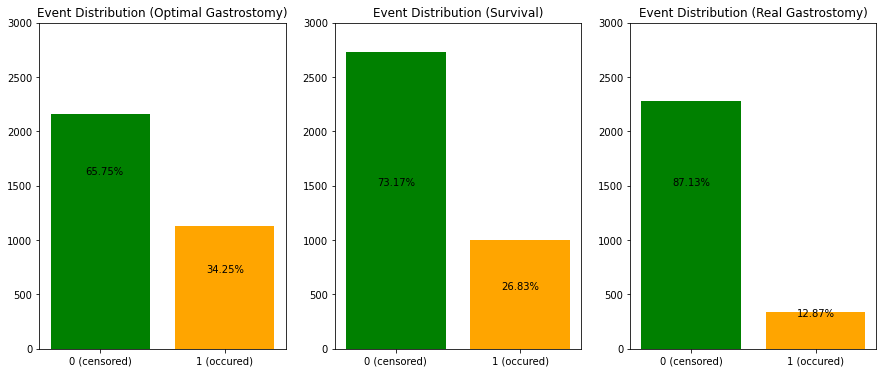

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.bar(event_distribution['status_o'], height=event_distribution['count'], color=['green', 'orange'])
plt.ylim([0,3000])
plt.title('Event Distribution (Optimal Gastrostomy)')
plt.text(-0.12,1600,per_0)
plt.text(0.85,700,per_1)

plt.subplot(132)
plt.bar(event_distribution_2['status_surv'], height=event_distribution_2['count'], color=['green', 'orange'])
plt.ylim([0,3000])
plt.title('Event Distribution (Survival)')
plt.text(-0.15,1500,perc_0)
plt.text(0.85,550,perc_1)

plt.subplot(133)
plt.bar(event_distribution_3['status_real'], height=event_distribution_3['count'], color=['green', 'orange'])
plt.ylim([0,3000])
plt.title('Event Distribution (Real Gastrostomy)')
plt.text(-0.15,1500,pe_0)
plt.text(0.85,300,pe_1)

plt.show()